In [2]:
%pylab inline
import os
import pandas as pd
from PIL import Image, ImageFilter, ImageOps
from sklearn import decomposition, cluster, svm, preprocessing, manifold, metrics, dummy
import cv2

Populating the interactive namespace from numpy and matplotlib


In [3]:
def dynamic_std_print(string_to_print):
    """
    Printing string on standard output and refreshing output line
    """
    sys.stdout.write('\r')
    sys.stdout.write(string_to_print)
    sys.stdout.flush()

# 1) Get data

Gather our files paths

In [4]:
# Get local path
local_path = os.getcwd()

In [5]:
# List images folders
breeds_folders = [local_path + "/data/images/" + file_name for file_name in os.listdir(local_path + "/data/images") if os.path.isdir(local_path + "/data/images/" + file_name)]

In [6]:
# List breeds id and name
breeds_id = [breed_path.split("/")[-1].split("-")[0] for breed_path in breeds_folders]
breeds_name = [breed_path.split("/")[-1].split("-")[-1] for breed_path in breeds_folders]
breed_dict = dict(zip(breeds_id, breeds_name))

In [7]:
# List all images names
images = []
dog_id = []
breed_id = []
breed_name = []
full_path = []
for breed_folder in breeds_folders:
    # Get full pictures names
    files = [picture for picture in os.listdir(breed_folder) if picture.startswith("n")]
    images.extend(files)
    # Get pictures breed id
    breed_ids = [bids[0] for bids in list(map(lambda x: x.split("_"), files))]
    breed_id.extend(breed_ids)
    # Get dog id
    dog_ids = [did[0] for did in list(map(lambda x: x.split("_")[1].split("."), files))]
    dog_id.extend(dog_ids)
    # Convert breed id to breed name
    breed_names = [breed_dict[bid] for bid in breed_ids]
    breed_name.extend(breed_names)
    # Create full path to pictures
    full_paths = [breed_folder + "/" + file for file in files]
    full_path.extend(full_paths)

Now that we have our lists of data, gather into dataframe

In [8]:
data_mat = np.array([images, breed_id, breed_name, dog_id, full_path]).T

In [9]:
dogs_df = pd.DataFrame(data_mat, columns=['picture', 'breed_id', 'breed_name', 'breed_dog_id', 'pic_full_path'])

Have a look

In [10]:
dogs_df.sample(5)

,picture,breed_id,breed_name,breed_dog_id,pic_full_path
11038,n02100877_4099.jpg,n02100877,Irish_setter,4099,/mnt/d/FORMATIONS/OCLR/0-PARCOURS-DATA_SCIENTI...
16462,n02109525_5007.jpg,n02109525,Saint_Bernard,5007,/mnt/d/FORMATIONS/OCLR/0-PARCOURS-DATA_SCIENTI...
8667,n02097298_1410.jpg,n02097298,Scotch_terrier,1410,/mnt/d/FORMATIONS/OCLR/0-PARCOURS-DATA_SCIENTI...
15879,n02108551_11671.jpg,n02108551,Tibetan_mastiff,11671,/mnt/d/FORMATIONS/OCLR/0-PARCOURS-DATA_SCIENTI...
11363,n02101388_4556.jpg,n02101388,Brittany_spaniel,4556,/mnt/d/FORMATIONS/OCLR/0-PARCOURS-DATA_SCIENTI...


# 2) Selecting train and test datasets

#### To begin with we will consider 5 breeds, 10 training pictures and 2 testing pictures for each breed

Select 5 random breeds

In [11]:
n_breeds = 5
breeds = pd.DataFrame(dogs_df.breed_id.unique()).sample(n_breeds, random_state=0).values

Select pictures for each breed

In [12]:
train_size = 10
test_size = 2
train_test_size = train_size + test_size
train_test_df = pd.DataFrame()
train_df = pd.DataFrame()
test_df = pd.DataFrame()
rmstate = np.random.RandomState(seed=0)
# For each sample breed
for breed in breeds:
    # Select breed sub df
    breed_df = dogs_df.loc[dogs_df['breed_id'] == breed[0]].loc[:, ['breed_name','pic_full_path']]
    breed_sample = breed_df.sample(train_test_size, random_state=0)
    # Shuffle index to get random train and test df
    breed_ind = breed_sample.index.values
    rmstate.shuffle(breed_ind)
    train_breed_ind = breed_ind[:train_size]
    test_breed_ind = breed_ind[train_size:]
    breed_train = breed_sample.loc[train_breed_ind, :]
    breed_test = breed_sample.loc[test_breed_ind, :]
    # Concatenate with main train-test df
    train_test_df = pd.concat((train_test_df, breed_sample))
    train_df = pd.concat((train_df, breed_train))
    test_df = pd.concat((test_df, breed_test))

# 3) Processing pictures

This first step aims to pre-process our pictures before extracting features

Steps are as follow :
- 1) Apply a Gaussian filter to delete noise by bluring picture
- 2) Apply histogram equalization
- 3) Transform picture into greyscale

In [89]:
rand_breed=train_df.breed_name.value_counts().sample(3, random_state=0).index.values
train_df[train_df.loc[:, 'breed_name'] == rand_breed[0]]

,breed_name,pic_full_path
16143,French_bulldog,/mnt/d/FORMATIONS/OCLR/0-PARCOURS-DATA_SCIENTI...
16118,French_bulldog,/mnt/d/FORMATIONS/OCLR/0-PARCOURS-DATA_SCIENTI...
16068,French_bulldog,/mnt/d/FORMATIONS/OCLR/0-PARCOURS-DATA_SCIENTI...
16133,French_bulldog,/mnt/d/FORMATIONS/OCLR/0-PARCOURS-DATA_SCIENTI...
16106,French_bulldog,/mnt/d/FORMATIONS/OCLR/0-PARCOURS-DATA_SCIENTI...
16030,French_bulldog,/mnt/d/FORMATIONS/OCLR/0-PARCOURS-DATA_SCIENTI...
16157,French_bulldog,/mnt/d/FORMATIONS/OCLR/0-PARCOURS-DATA_SCIENTI...
16154,French_bulldog,/mnt/d/FORMATIONS/OCLR/0-PARCOURS-DATA_SCIENTI...
16082,French_bulldog,/mnt/d/FORMATIONS/OCLR/0-PARCOURS-DATA_SCIENTI...
16063,French_bulldog,/mnt/d/FORMATIONS/OCLR/0-PARCOURS-DATA_SCIENTI...


In [13]:
# Initialize our features matrix
sift_features_train = np.empty((1, 128))
pic_features_train = []
# Number of pictures
n_pic_train = train_df.shape[0]
n_feats_train = 0
pictures_descriptors_train = []

count = 1
for picture_id, picture_path in zip(train_df.index.values, train_df.pic_full_path.values):
    dynamic_std_print("Treating picture ({:d} / {:d})      ".format(count, n_pic_train))
    
    # Load the picture
    img = Image.open(picture_path)
    
    # Apply gaussian filter
    gaussian_img = img.filter(ImageFilter.GaussianBlur(radius=1))
    
    # Apply histogram equalization
    equalized_img = ImageOps.equalize(gaussian_img, mask=None)

    # Get picture's matrix
    img_mat = np.array(equalized_img)
    
    # Convert to greyscale
    img_grey_mat = cv2.cvtColor(img_mat, cv2.COLOR_BGR2GRAY)
    
    # Generate SIFT features (limiting to 100 features)
    sift = cv2.xfeatures2d.SIFT_create(100)
    keypoints, descriptors = sift.detectAndCompute(img_grey_mat, None)
    pictures_descriptors_train.append(descriptors)
    
    # Number of features
    n_feat_img = len(keypoints)
    n_feats_train = n_feats_train + n_feat_img
    
    # Concatenate descriptors
    sift_features_train = np.concatenate((sift_features_train, descriptors))
    # Add picture value
    pic_features_train.extend([count-1]*len(descriptors))
    
    count += 1

# Remove 1st empty column
sift_features_train = sift_features_train[1:, :]

Treating picture (50 / 50)      

In [14]:
# Initialize our features matrix
sift_features_test = np.empty((1, 128))
pic_features_test = []
# Number of pictures
n_pic_test = test_df.shape[0]
n_feats_test = 0
pictures_descriptors_test = []

count = 1
for picture_id, picture_path in zip(test_df.index.values, test_df.pic_full_path.values):
    dynamic_std_print("Treating picture ({:d} / {:d})      ".format(count, n_pic_test))
    
    # Load the picture
    img = Image.open(picture_path)
    
    # Apply gaussian filter
    gaussian_img = img.filter(ImageFilter.GaussianBlur(radius=1))
    
    # Apply histogram equalization
    equalized_img = ImageOps.equalize(gaussian_img, mask=None)

    # Get picture's matrix
    img_mat = np.array(equalized_img)
    
    # Convert to greyscale
    img_grey_mat = cv2.cvtColor(img_mat, cv2.COLOR_BGR2GRAY)
    
    # Generate SIFT features (limiting to 100 features)
    sift = cv2.xfeatures2d.SIFT_create(100)
    keypoints, descriptors = sift.detectAndCompute(img_grey_mat, None)
    pictures_descriptors_test.append(descriptors)
    
    # Number of features
    n_feat_img = len(keypoints)
    n_feats_test = n_feats_test + n_feat_img
    
    # Concatenate descriptors
    sift_features_test = np.concatenate((sift_features_test, descriptors))
    # Add picture value
    pic_features_test.extend([count-1]*len(descriptors))
    
    count += 1

# Remove 1st empty column
sift_features_test = sift_features_test[1:, :]

Treating picture (10 / 10)      

In [15]:
print("Found %i SIFT features in %i pictures" % (sift_features_train.shape[0], count-1))

Found 5006 SIFT features in 10 pictures


# 3.2) Visualizing features

In [16]:
print(sift_features_train.shape)

(5006, 128)


We need to reduce our features dimension in order to be able to visualize them

#### Apply PCA

In [17]:
ratios = []
components = np.arange(2, 107, 5)
for i in components:
    dynamic_std_print("Treating {:d}".format(i))
    visu_pca = decomposition.PCA(n_components=i)
    visu_pca.fit(sift_features_train)
    ratios.append(visu_pca.explained_variance_ratio_.sum())

Treating 102

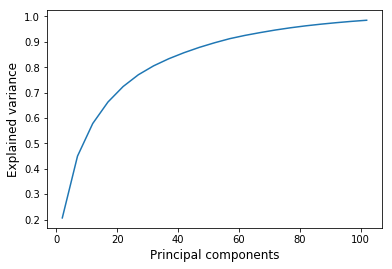

In [18]:
plt.plot(components, ratios)
plt.xlabel('Principal components', fontsize=12)
plt.ylabel('Explained variance', fontsize=12);

In [19]:
# Transform features with PCA
visu_pca = decomposition.PCA(n_components=50)
visu_pca.fit(sift_features_train)
sift_feats_train_pca = visu_pca.transform(sift_features_train)

In [20]:
sift_feats_train_pca.shape

(5006, 50)

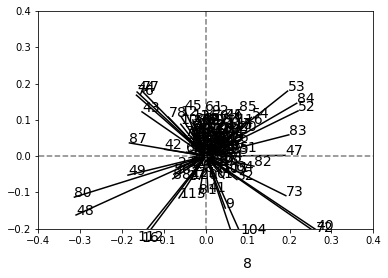

In [21]:
pcs = visu_pca.components_
for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    # Afficher un segment de l'origine au point (x, y)
    plt.plot([0, x], [0, y], color='k')
    # Afficher le nom (data.columns[i]) de la performance
    plt.text(x, y, i, fontsize='14')
# Afficher une ligne horizontale y=0
plt.plot([-0.7, 0.7], [0, 0], color='grey', ls='--')
# Afficher une ligne verticale x=0
plt.plot([0, 0], [-0.7, 0.7], color='grey', ls='--')
plt.xlim([-0.4, 0.4])
plt.ylim([-0.2, 0.4]);

Several features seem greatly correlated or negatively correlated

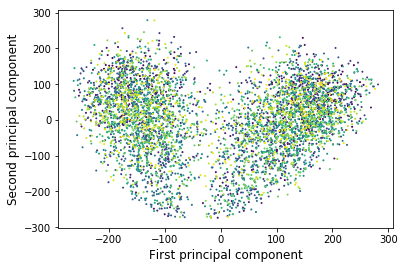

In [24]:
plt.scatter(sift_feats_train_pca[:,0], sift_feats_train_pca[:,1], s=1, c=pic_features_train)
plt.xlabel('First principal component', fontsize=12)
plt.ylabel('Second principal component', fontsize=12);

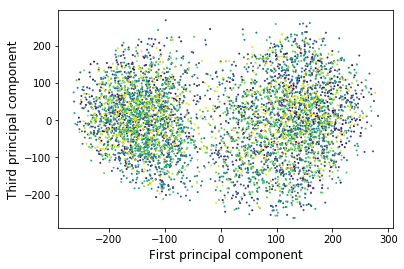

In [25]:
plt.scatter(sift_feats_train_pca[:,0], sift_feats_train_pca[:,2], s=1, c=pic_features_train)
plt.xlabel('First principal component', fontsize=12)
plt.ylabel('Third principal component', fontsize=12);

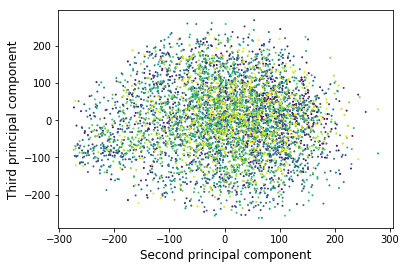

In [31]:
plt.scatter(sift_feats_train_pca[:,1], sift_feats_train_pca[:,2], s=1, c=pic_features_train)
plt.xlabel('Second principal component', fontsize=12)
plt.ylabel('Third principal component', fontsize=12);

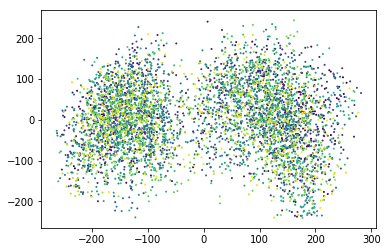

In [27]:
plt.scatter(sift_feats_train_pca[:,0], sift_feats_train_pca[:,3], s=1, c=pic_features_train);

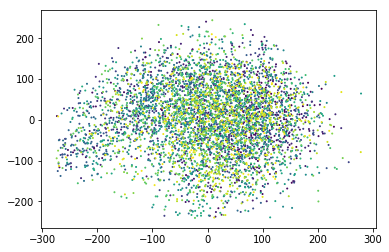

In [28]:
plt.scatter(sift_feats_train_pca[:,1], sift_feats_train_pca[:,3], s=1, c=pic_features_train);

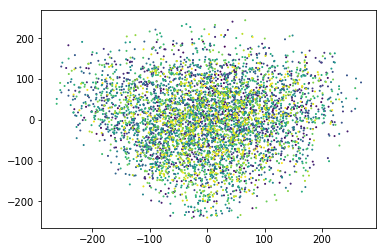

In [29]:
plt.scatter(sift_feats_train_pca[:,2], sift_feats_train_pca[:,3], s=1, c=pic_features_train);

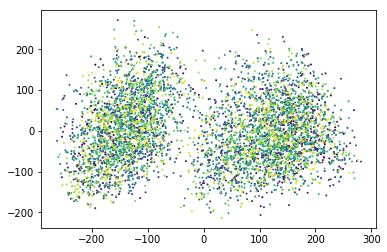

In [30]:
plt.scatter(sift_feats_train_pca[:,0], sift_feats_train_pca[:,4], s=1, c=pic_features_train);

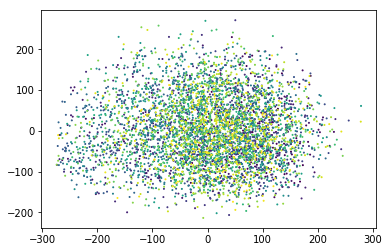

In [32]:
plt.scatter(sift_feats_train_pca[:,1], sift_feats_train_pca[:,4], s=1, c=pic_features_train);

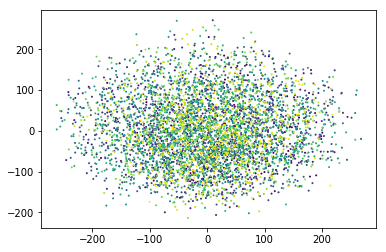

In [33]:
plt.scatter(sift_feats_train_pca[:,2], sift_feats_train_pca[:,4], s=1, c=pic_features_train);

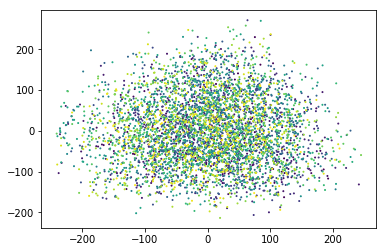

In [34]:
plt.scatter(sift_feats_train_pca[:,3], sift_feats_train_pca[:,4], s=1, c=pic_features_train);

#### Apply tSNE

In [35]:
idx = np.arange(0, len(sift_features_train))
rmstate = np.random.RandomState(0)
rmstate.shuffle(idx)
# idx = idx[:10000]

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5006 samples in 0.024s...
[t-SNE] Computed neighbors for 5006 samples in 6.006s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5006
[t-SNE] Computed conditional probabilities for sample 2000 / 5006
[t-SNE] Computed conditional probabilities for sample 3000 / 5006
[t-SNE] Computed conditional probabilities for sample 4000 / 5006
[t-SNE] Computed conditional probabilities for sample 5000 / 5006
[t-SNE] Computed conditional probabilities for sample 5006 / 5006
[t-SNE] Mean sigma: 98.974601
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.000320
[t-SNE] KL divergence after 1000 iterations: 2.551613


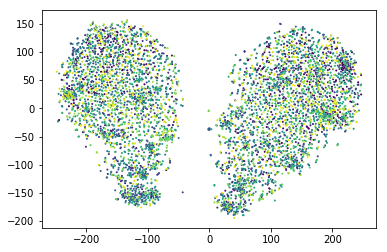

In [36]:
tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=1000, init='pca', verbose=1)
sift_features_tsne = tsne.fit_transform(sift_features_train)
plt.scatter(sift_features_tsne[:,0], sift_features_tsne[:,1], s=1, c=pic_features_train);

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5006 samples in 0.016s...
[t-SNE] Computed neighbors for 5006 samples in 5.435s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5006
[t-SNE] Computed conditional probabilities for sample 2000 / 5006
[t-SNE] Computed conditional probabilities for sample 3000 / 5006
[t-SNE] Computed conditional probabilities for sample 4000 / 5006
[t-SNE] Computed conditional probabilities for sample 5000 / 5006
[t-SNE] Computed conditional probabilities for sample 5006 / 5006
[t-SNE] Mean sigma: 98.974601
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.899559
[t-SNE] KL divergence after 251 iterations: 179769313486231570814527423731704356798070567525844996598917476803157260780028538760589558632766878171540458953514382464234321326889464182768467546703537516986049910576551282076245490090389328944075868508455133942304583236903222948165808559332123348274797826204144723168738177180919299881250404026184124858368.0

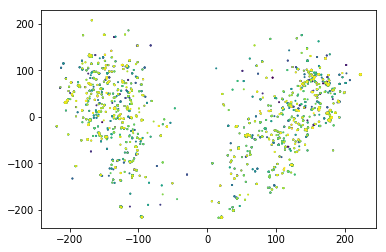

In [37]:
tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=250, init='pca', verbose=1)
sift_features_tsne = tsne.fit_transform(sift_features_train)
plt.scatter(sift_features_tsne[:,0], sift_features_tsne[:,1], s=1, c=pic_features_train);

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 5006 samples in 0.015s...
[t-SNE] Computed neighbors for 5006 samples in 5.249s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5006
[t-SNE] Computed conditional probabilities for sample 2000 / 5006
[t-SNE] Computed conditional probabilities for sample 3000 / 5006
[t-SNE] Computed conditional probabilities for sample 4000 / 5006
[t-SNE] Computed conditional probabilities for sample 5000 / 5006
[t-SNE] Computed conditional probabilities for sample 5006 / 5006
[t-SNE] Mean sigma: 83.225550
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.065338
[t-SNE] KL divergence after 251 iterations: 179769313486231570814527423731704356798070567525844996598917476803157260780028538760589558632766878171540458953514382464234321326889464182768467546703537516986049910576551282076245490090389328944075868508455133942304583236903222948165808559332123348274797826204144723168738177180919299881250404026184124858368.0

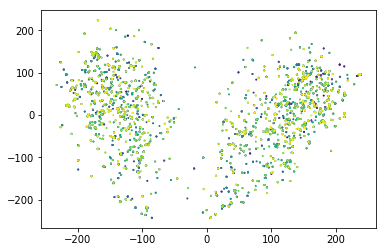

In [38]:
tsne = manifold.TSNE(n_components=2, perplexity=10, n_iter=250, init='pca', verbose=1)
sift_features_tsne = tsne.fit_transform(sift_features_train)
plt.scatter(sift_features_tsne[:,0], sift_features_tsne[:,1], s=1, c=pic_features_train);

# 4) Output Bag of Visual Words

Now that we have our features we will turn those into Bags of Visual Words through a KMeans clustering which cluster centers will be our Visual Words

Problem is : training our clusters takes a lot of computational capabilities.

Solution : Apply PCA dimensionality reduction before clustering __(IF NEEDED)__

In [39]:
sift_features_bow = sift_features_train
sift_features_bow.shape

(5006, 128)

#### Apply PCA for dimensionality reduction

In [40]:
# sift_components = np.arange(50, 120, 5)
# ok_var = 0.9
# for i in sift_components:
#     dynamic_std_print("Treating {:d}".format(i))
#     sift_pca = decomposition.PCA(n_components=i)
#     sift_pca.fit(sift_features)
#     if sift_pca.explained_variance_ratio_.sum() >= ok_var:
#         break
    
# # n_comp_pca = 57
# n_comp_pca = i
# pca_bow = decomposition.PCA(n_components=n_comp_pca)
# pca_bow.fit(sift_features)
# pca_bow.explained_variance_ratio_.sum()

We look to explain 90% of the features variance

In [41]:
# sift_features_bow = pca_bow.transform(sift_features)
# sift_features_bow.shape

#### Gather our features in bag of visuals words through kmeans clustering

In [42]:
n_clust = int(np.floor(np.sqrt(sift_features_bow.shape[0])))
n_clust

70

In [43]:
kmeans = cluster.KMeans(n_clusters=n_clust, verbose=1, n_jobs=-1, algorithm='full')
kmeans.fit(sift_features_bow);

Initialization complete
Iteration  0, inertia 624325331.000
Iteration  1, inertia 432892816.922
Iteration  2, inertia 423696471.335
Iteration  3, inertia 419412255.913
Iteration  4, inertia 416769710.820
Iteration  5, inertia 414961911.775
Iteration  6, inertia 413651643.600
Iteration  7, inertia 412568167.238
Iteration  8, inertia 411529110.423
Iteration  9, inertia 410867381.346
Iteration 10, inertia 410328454.330
Iteration 11, inertia 409971024.009
Iteration 12, inertia 409661501.119
Iteration 13, inertia 409478681.302
Iteration 14, inertia 409313509.768
Iteration 15, inertia 409172104.268
Iteration 16, inertia 409085648.392
Iteration 17, inertia 408971582.517
Iteration 18, inertia 408879987.421
Iteration 19, inertia 408808483.402
Iteration 20, inertia 408681561.052
Iteration 21, inertia 408579019.469
Iteration 22, inertia 408504751.847
Iteration 23, inertia 408450604.056
Iteration 24, inertia 408390256.602
Iteration 25, inertia 408317500.030
Iteration 26, inertia 408233840.733
Iter

Iteration 13, inertia 410044635.547
Iteration 14, inertia 409944725.956
Iteration 15, inertia 409858656.781
Iteration 16, inertia 409808831.136
Iteration 17, inertia 409772362.106
Iteration 18, inertia 409734823.888
Iteration 19, inertia 409707771.754
Iteration 20, inertia 409685773.957
Iteration 21, inertia 409672110.645
Iteration 22, inertia 409659281.910
Iteration 23, inertia 409650409.935
Iteration 24, inertia 409647423.423
Iteration 25, inertia 409643367.636
Converged at iteration 25: center shift 0.000000e+00 within tolerance 1.145409e-01
Initialization complete
Iteration  0, inertia 632773374.000
Iteration  1, inertia 431619999.206
Iteration  2, inertia 422317551.197
Iteration  3, inertia 418393672.062
Iteration  4, inertia 415911640.677
Iteration  5, inertia 414368491.051
Iteration  6, inertia 413372189.972
Iteration  7, inertia 412577643.187
Iteration  8, inertia 411950609.275
Iteration  9, inertia 411528601.073
Iteration 10, inertia 411149095.598
Iteration 11, inertia 4108740

The clusters centers are our visual words

In [44]:
kmeans.cluster_centers_.shape

(70, 128)

In [45]:
kmeans.cluster_centers_.shape

(70, 128)

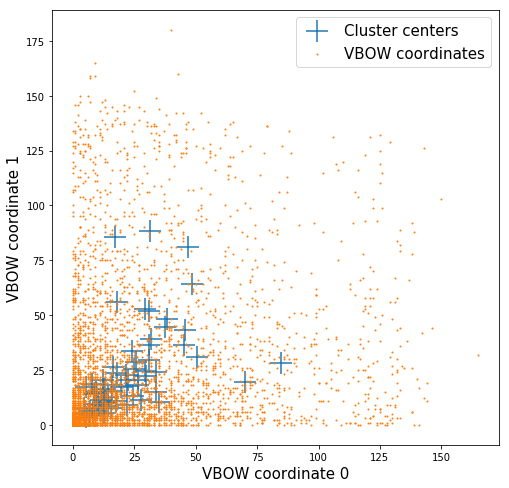

In [46]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=500, marker='+', label='Cluster centers')
ax.scatter(sift_features_bow[:, 0], sift_features_bow[:, 1], s=1, label='VBOW coordinates')
ax.legend(fontsize=15)
ax.set_xlabel('VBOW coordinate 0', fontsize=15)
ax.set_ylabel('VBOW coordinate 1', fontsize=15);

In [47]:
colors = kmeans.predict(sift_features_bow)

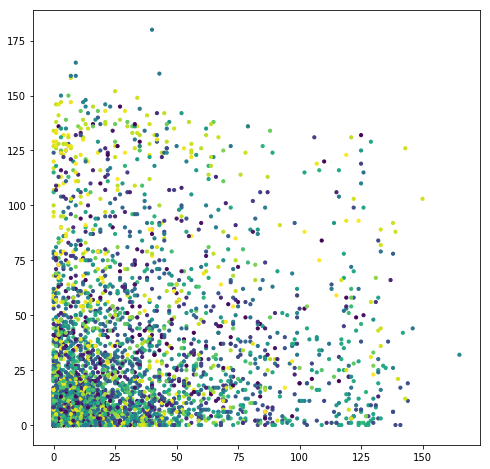

In [48]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(sift_features_bow[:, 0], sift_features_bow[:, 1], s=10, c=colors);

# 5) Create histograms for each picture

We now create histograms showing our features frequency in each picture

In [49]:
pictures_descriptors_bow = pictures_descriptors_train

#### Apply PCA for dimensionality reduction

In [50]:
# pictures_descriptors_bow = []
# for img_desc in pictures_descriptors:
#     pictures_descriptors_bow.append(pca_bow.transform(img_desc))

#### Get histograms from reduced pictures SIFT descriptors

In [51]:
histograms_train = []
for img_desc_red in pictures_descriptors_bow:
    predict_kmeans = kmeans.predict(img_desc_red)
    hist, bins = np.histogram(predict_kmeans, bins=n_clust)
    histograms_train.append(hist)

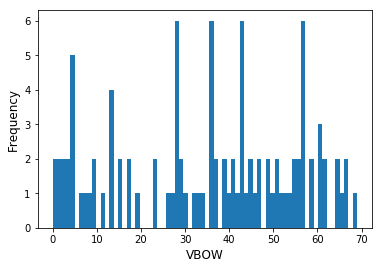

In [52]:
plt.hist(predict_kmeans, bins=n_clust)
plt.xlabel('VBOW', fontsize=12)
plt.ylabel('Frequency', fontsize=12);

Histograms for test pictures

In [53]:
histograms_test = []
for img_desc_red in pictures_descriptors_test:
    predict_kmeans = kmeans.predict(img_desc_red)
    hist, bins = np.histogram(predict_kmeans, bins=n_clust)
    histograms_test.append(hist)

# 6) Separate into train and test datasets

Now that we have our explanatory features : our histograms, we can learn from it and try to predict breeds, first separate our histograms into training and testing datasets

In [54]:
histo_df_train = pd.DataFrame(histograms_train)
histo_df_train.index = train_df.index
histo_df_test = pd.DataFrame(histograms_test)
histo_df_test.index = test_df.index

In [56]:
new_train_df = pd.concat((train_df, histo_df_train[histo_df_train.index.isin(train_df.index)]), axis=1)
new_train_df = new_train_df.drop(labels=['pic_full_path'], axis=1)
new_test_df = pd.concat((test_df, histo_df_test[histo_df_test.index.isin(test_df.index)]), axis=1)
new_test_df = new_test_df.drop(labels=['pic_full_path'], axis=1)

In [57]:
new_train_df.sample(5)

,breed_name,0,1,2,3,4,5,6,7,8,...,60,61,62,63,64,65,66,67,68,69
16219,Great_Dane,1,2,2,4,1,1,1,1,2,...,0,2,1,4,2,0,4,0,0,1
8771,Scotch_terrier,3,1,0,3,1,0,3,4,3,...,1,1,1,0,1,0,0,0,0,2
16272,Great_Dane,1,0,2,1,0,1,3,0,1,...,2,1,3,2,1,1,0,1,0,1
1562,Rhodesian_ridgeback,2,1,2,2,1,0,0,0,1,...,0,1,4,0,3,1,7,1,2,3
16030,French_bulldog,2,1,2,0,2,3,2,0,2,...,1,2,2,0,5,1,1,0,0,1


# 7) Train classifier

Learn on train dataset

In [58]:
breeds_unique = train_df.breed_name.unique()
le = preprocessing.LabelEncoder()
le.fit(breeds_unique);

In [59]:
target_training = le.transform(new_train_df.breed_name.values).reshape(-1,)
target_testing = le.transform(new_test_df.breed_name.values).reshape(-1,)

In [60]:
new_train_df.shape

(50, 71)

In [61]:
training_svm = svm.LinearSVC()
training_svm.fit(new_train_df.loc[:, new_train_df.columns != 'breed_name'].values, target_training)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [62]:
prediction = training_svm.predict(new_test_df.loc[:, new_test_df.columns != 'breed_name'].values)
prediction_breeds = le.inverse_transform(prediction)

In [63]:
res_mat = np.concatenate((prediction_breeds.reshape(-1,1), new_test_df.breed_name.values.reshape(-1,1)), axis=1)
res_df = pd.DataFrame(res_mat, columns=['Predicted', 'True_Breed'])
res_df['Accurate'] = res_df.Predicted == res_df.True_Breed
res_df

,Predicted,True_Breed,Accurate
0,Great_Dane,Scotch_terrier,False
1,Eskimo_dog,Scotch_terrier,False
2,French_bulldog,French_bulldog,True
3,Scotch_terrier,French_bulldog,False
4,French_bulldog,Great_Dane,False
5,French_bulldog,Great_Dane,False
6,Rhodesian_ridgeback,Rhodesian_ridgeback,True
7,Rhodesian_ridgeback,Rhodesian_ridgeback,True
8,French_bulldog,Eskimo_dog,False
9,French_bulldog,Eskimo_dog,False


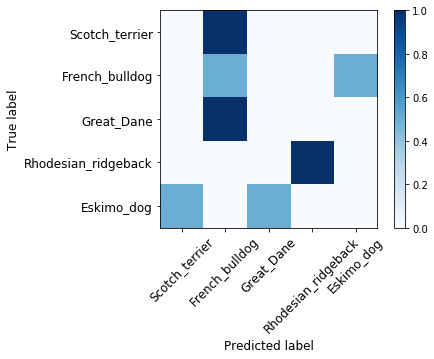

In [64]:
cm = metrics.confusion_matrix(res_df.loc[:,'True_Breed'], res_df.loc[:,'Predicted'])
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
classes = res_df.loc[:,'True_Breed'].unique()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
plt.yticks(tick_marks, classes, fontsize=12)
plt.ylabel('True label', fontsize=12)
plt.xlabel('Predicted label', fontsize=12);

In [65]:
classification_score = training_svm.score(new_test_df.loc[:, new_test_df.columns != 'breed_name'].values, target_testing)
print("The model achieves a classification score of %.2f" % classification_score)

The model achieves a classification score of 0.30


Train dummy classifier for comparison

In [66]:
mean_rand = []
for i in range(5000):
    random_pred = []
    for target in target_testing :
        random_pred.append(np.random.randint(target_testing.min(), target_testing.max()))
    random_pred = np.array(random_pred)
    mean_rand.append(np.equal(target_testing.reshape(-1), random_pred).sum() / len(target_testing))
mean(mean_rand)

0.20016